# Neural Network classification with PyTorch

Classification is predicting whether something is one thing or the other (can have multiple options)

## Data


In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [5]:
print(y[:5]) # Binary classification

[1 1 1 1 0]


In [6]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:, 1],
                         "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


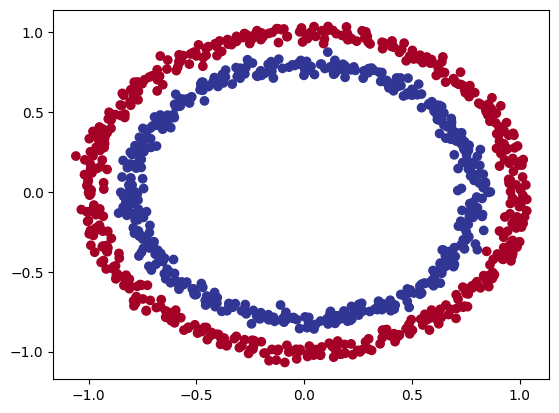

In [7]:
# Graphical
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

## The data we are working with is referred to a toy dataset, small enough to experiment on but sizeable enough

# Check input and output shapes

In [8]:
X.shape, y.shape # 2 represents the number of features

((1000, 2), (1000,))

In [9]:
X # array need change to tensor

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
X_sample = X[0]
y_sample = y[0]

print(f"{X_sample},{X_sample.shape}\n {y_sample},{y_sample.shape}")

[0.75424625 0.23148074],(2,)
 1,()


# Turn data into tensors

In [11]:
import torch
torch.__version__

'2.1.0+cu121'

In [12]:
type(X)

numpy.ndarray

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # alias for float32, default for numpy is float64
y = torch.from_numpy(y).type(torch.float)

In [14]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [15]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [16]:
# Splitting data into training and data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test
                                                    random_state=42) # random seed


In [17]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Classify blue and red dots

To do so:
1. Device agnostic code
2. Construct a model (by subclassing `nn.Module`) - almost all models need this
3. Define a loss function and optimizer
4. Training and testing loop


In [18]:
import torch
from torch import nn

# device agnostic
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cpu'

# Creating model
1. Subclass nn.Module
2. Create 2 nn.Linear() layers
3. def forward()
4. Instantiate an instance of model class and send to device

In [19]:
X_train[0:5] # size 2

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]])

In [20]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    # 2 linear layers to handle the shape of X data
    self.layer_1 = nn.Linear(in_features=2, # takes in 2 features (shape of X) and upscales to 5 features
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5, # takes in 5 features from previous layer and outputs a single feature (shape of y)
                             out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer2 -> output

model_0 = CircleModel().to(device)

In [21]:
next(model_0.parameters()).device

device(type='cpu')

In [22]:
# Let's replicate using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,
              out_features=5),
    nn.Linear(in_features=5,
              out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0692,  0.0372],
                      [ 0.6055, -0.6098],
                      [-0.3527,  0.0449],
                      [-0.2705,  0.2559],
                      [ 0.4006,  0.1134]])),
             ('0.bias', tensor([-0.6786, -0.5304,  0.6241, -0.5224,  0.1178])),
             ('1.weight',
              tensor([[ 0.2601, -0.1659, -0.1635, -0.2707, -0.0175]])),
             ('1.bias', tensor([0.2493]))])

In [24]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [25]:
len(X_test), X_test.shape

(200, torch.Size([200, 2]))

In [26]:
untrained_preds[:10], y_test[:10]

(tensor([[0.2046],
         [0.2297],
         [0.1588],
         [0.2175],
         [0.1908],
         [0.2058],
         [0.2513],
         [0.2458],
         [0.1576],
         [0.2318]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [27]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [28]:
torch.set_printoptions(sci_mode=False)

In [29]:
untrained_preds[:10], y_test[:10]

(tensor([[0.2046],
         [0.2297],
         [0.1588],
         [0.2175],
         [0.1908],
         [0.2058],
         [0.2513],
         [0.2458],
         [0.1576],
         [0.2318]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

# Loss function and optimizers

Loss functions:
for regression, use MAE or MSE (mean squared error)

for classification, use binary cross entropy or categorical cross entropy (referred to a simply, cross entropy)


optimizers:
common ones are SGD and Adam

In [30]:
# Loss function

# nn.BCELoss requires inputs to have gone through the sigmoid activation function prior to BCEloss
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()) provides less numerical stability

loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0692,  0.0372],
                      [ 0.6055, -0.6098],
                      [-0.3527,  0.0449],
                      [-0.2705,  0.2559],
                      [ 0.4006,  0.1134]])),
             ('0.bias', tensor([-0.6786, -0.5304,  0.6241, -0.5224,  0.1178])),
             ('1.weight',
              tensor([[ 0.2601, -0.1659, -0.1635, -0.2707, -0.0175]])),
             ('1.bias', tensor([0.2493]))])

In [32]:
# Calculate accuracy - out of 100 examples, what percentage is correct

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100

  return acc

# Train model

### Going from raw logits --> prediction probabilities --> prediction labels

Our model outputs are raw **logits**.

Can convert these logits into prediction probabilities by passing them to activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then convert prediction probabilities to **prediction labels** by rounding them or taking argmax()

In [33]:
# View first 5 outputs of forward pass on test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2046],
        [0.2297],
        [0.1588],
        [0.2175],
        [0.1908]])

In [34]:
# Use sigmoid activation function on model logits to turn into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5510],
        [0.5572],
        [0.5396],
        [0.5542],
        [0.5475]])

In [35]:
# if y < 0.5, y = 0 (class 0) else y = 1 (class 1) (decision boundary)
torch.round(y_pred_probs), y_test[:5]

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([1., 0., 1., 0., 1.]))

In [36]:
y_preds = torch.round(y_pred_probs)

# in full (logits to pred probs to pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))


# Check equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [37]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [38]:
# Training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into pred probs into pred labels

  loss = loss_fn(y_logits, y_train) # Loss function we specified requires logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69788, Acc: 50.00% | Test loss: 0.69881, Test acc: 50.00%
Epoch: 10 | Loss: 0.69435, Acc: 50.00% | Test loss: 0.69567, Test acc: 50.00%
Epoch: 20 | Loss: 0.69342, Acc: 58.75% | Test loss: 0.69485, Test acc: 56.50%
Epoch: 30 | Loss: 0.69317, Acc: 53.12% | Test loss: 0.69464, Test acc: 48.50%
Epoch: 40 | Loss: 0.69309, Acc: 52.75% | Test loss: 0.69459, Test acc: 47.00%
Epoch: 50 | Loss: 0.69305, Acc: 50.88% | Test loss: 0.69458, Test acc: 48.00%
Epoch: 60 | Loss: 0.69303, Acc: 50.75% | Test loss: 0.69458, Test acc: 47.50%
Epoch: 70 | Loss: 0.69302, Acc: 50.88% | Test loss: 0.69459, Test acc: 47.00%
Epoch: 80 | Loss: 0.69301, Acc: 51.12% | Test loss: 0.69460, Test acc: 47.50%
Epoch: 90 | Loss: 0.69301, Acc: 51.25% | Test loss: 0.69460, Test acc: 47.00%
Epoch: 100 | Loss: 0.69300, Acc: 51.25% | Test loss: 0.69461, Test acc: 47.00%
Epoch: 110 | Loss: 0.69300, Acc: 50.88% | Test loss: 0.69462, Test acc: 47.00%
Epoch: 120 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69463, T

# Make predictions and evaluate model
It looks like the model is not learning anything so
lets make some predictions and make them visualise

To do so, we need to import a function called plot_decision_boundary()

In [58]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("already exists, skipping download")

else:
  print("downloaded")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

already exists, skipping download


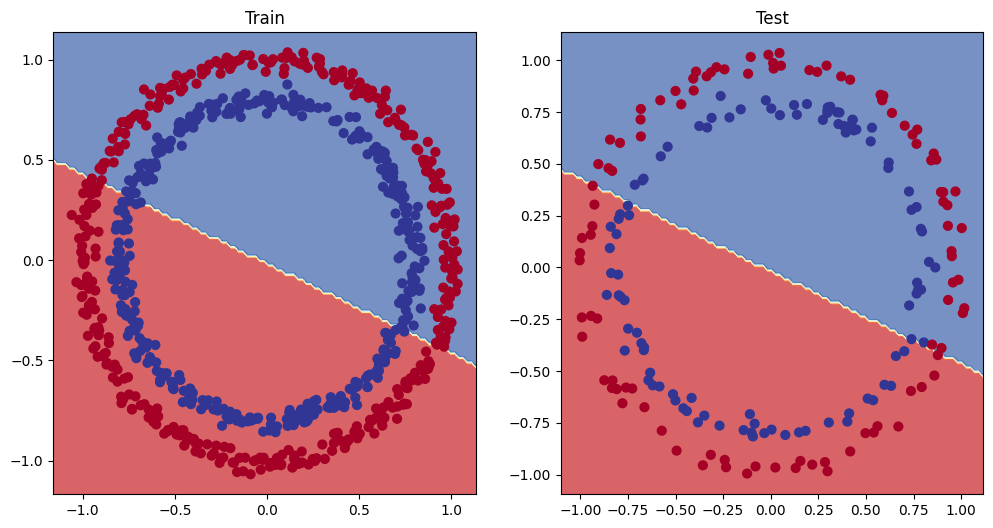

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving the model
1. Add more layers
2. Add more hidden units (go from 5 hidden units to 10 hidden units)
3. More epochs
4. Changing the activation function
5. Change the learning rate
6. Change the loss function

These are what we can change so they are **hyperparameters**

These affect the model not the data, you can also have more data to improve

In [41]:
# Increasing hidden units and layers and epochs

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=50)
    self.layer_3 = nn.Linear(in_features=50, out_features=1)


  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # Speed ups if u keep it in one line

In [42]:
model_1 = CircleModelV1().to(device)

In [43]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epochs: {epoch} | Training loss: {loss:.5f}, Training accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")


Epochs: 0 | Training loss: 0.69467, Training accuracy: 49.50% | Test loss: 0.69830, Test accuracy: 48.50%
Epochs: 100 | Training loss: 0.69298, Training accuracy: 51.38% | Test loss: 0.69480, Test accuracy: 45.50%
Epochs: 200 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69469, Test accuracy: 46.00%
Epochs: 300 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 400 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 500 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 600 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 700 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 800 | Training loss: 0.69298, Training accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epochs: 900 | Training loss: 0

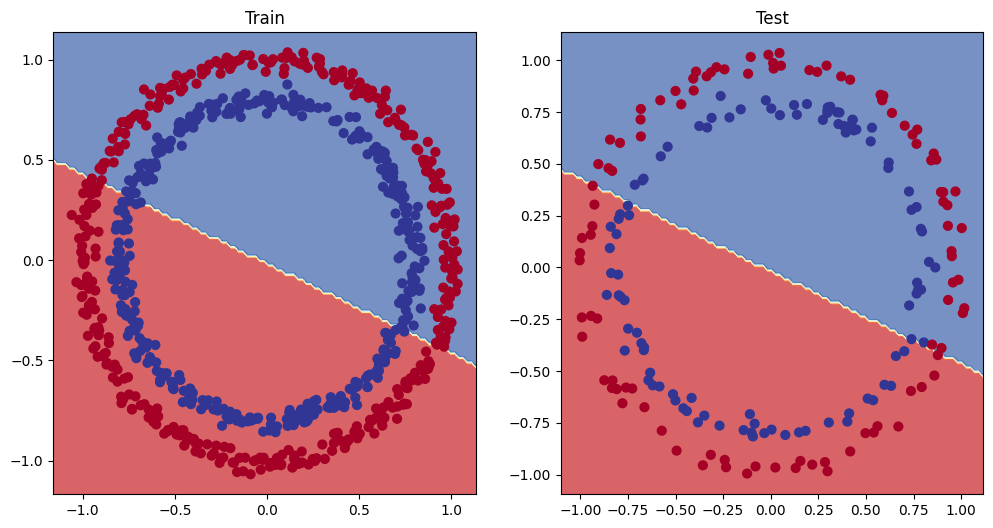

In [45]:
# Plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## The missing piece is non-linearity activations

Must give model ability to combine linear and non-linear functions to fit different types of curves

Neural networks are a large combination of linear and non-linear functions

### Recreating non-linear data (red and blue circles)

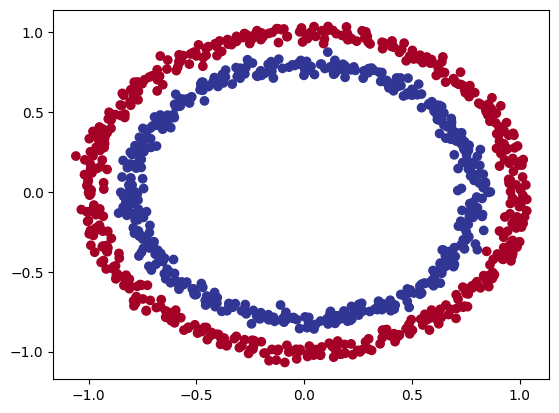

In [46]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [47]:
# Convert data to tensors
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [48]:
### Building a model with non-linearity
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=20)
    self.layer_2 = nn.Linear(in_features=20, out_features=20)
    self.layer_3 = nn.Linear(in_features=20, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
# Loss function and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [50]:
# Training a model with non-linearity

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 3000

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epochs: {epoch} || Training loss: {loss:.5f}, Training accuracy: {acc:.2f}% || Testing loss: {test_loss:.5f}, Testing accuracy: {test_acc:.2f}%")

Epochs: 0 || Training loss: 0.69448, Training accuracy: 47.62% || Testing loss: 0.69197, Testing accuracy: 54.00%
Epochs: 100 || Training loss: 0.69102, Training accuracy: 53.12% || Testing loss: 0.68961, Testing accuracy: 56.50%
Epochs: 200 || Training loss: 0.68750, Training accuracy: 56.88% || Testing loss: 0.68704, Testing accuracy: 57.00%
Epochs: 300 || Training loss: 0.68379, Training accuracy: 59.62% || Testing loss: 0.68357, Testing accuracy: 59.50%
Epochs: 400 || Training loss: 0.67821, Training accuracy: 63.12% || Testing loss: 0.67807, Testing accuracy: 63.00%
Epochs: 500 || Training loss: 0.66898, Training accuracy: 69.50% || Testing loss: 0.66913, Testing accuracy: 72.00%
Epochs: 600 || Training loss: 0.65292, Training accuracy: 75.38% || Testing loss: 0.65433, Testing accuracy: 77.00%
Epochs: 700 || Training loss: 0.62314, Training accuracy: 85.62% || Testing loss: 0.62753, Testing accuracy: 84.00%
Epochs: 800 || Training loss: 0.56539, Training accuracy: 94.62% || Testin

In [51]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

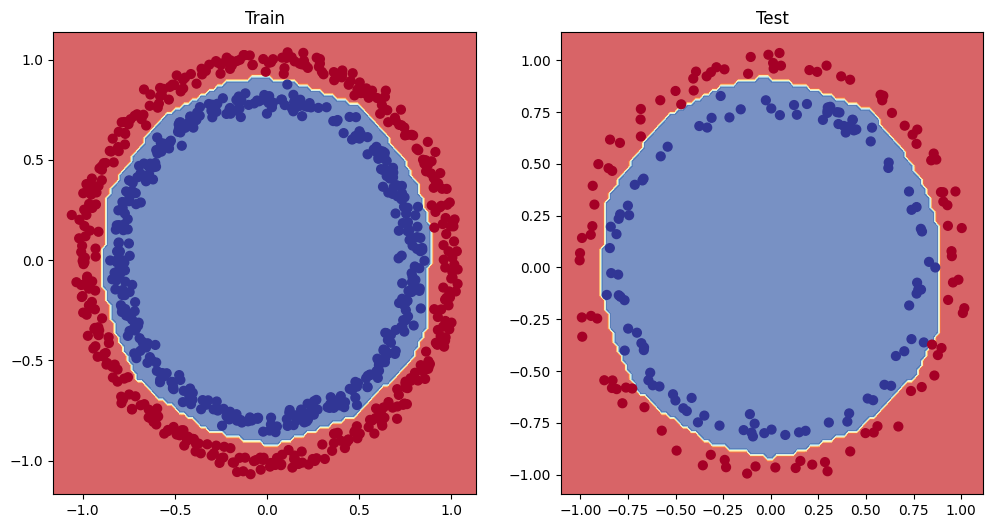

In [52]:
# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [53]:
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

# Replicating non-linear activation functions

In [54]:
# Create tensor
A = torch.arange(-10, 10, 1, dtype=torch.float)
A.dtype

torch.float32

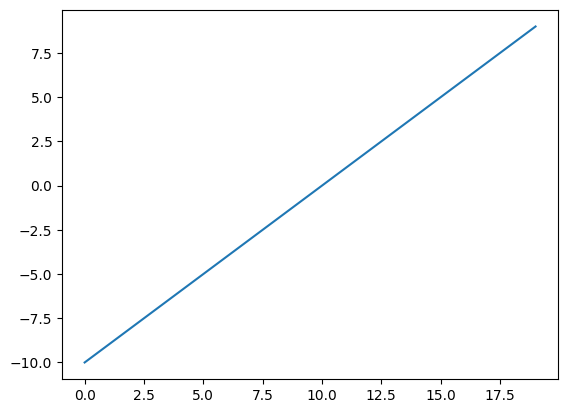

In [55]:
# Visualise
plt.plot(A);

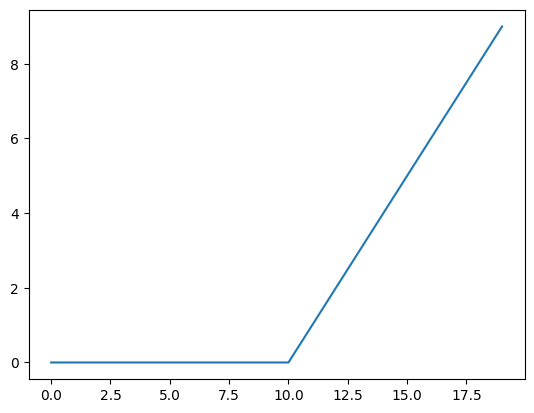

In [56]:
plt.plot(torch.relu(A));

In [57]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

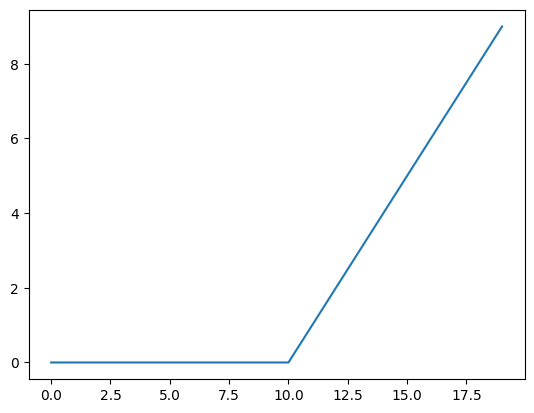

In [58]:
# Plot ReLU activation function
plt.plot(relu(A));

In [59]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

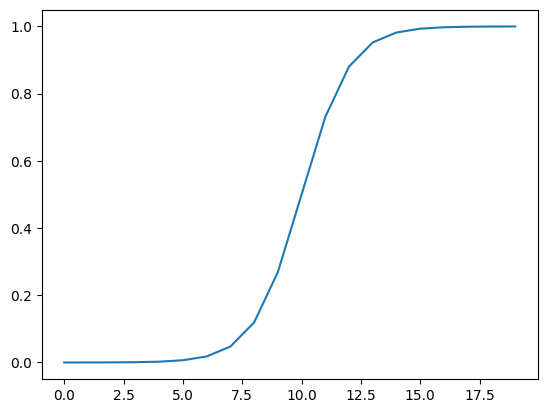

In [60]:
plt.plot(sigmoid(A));

## Multiclass classification problem

Binary classification - one thing or another

Multiclass classification - more than one thing or another

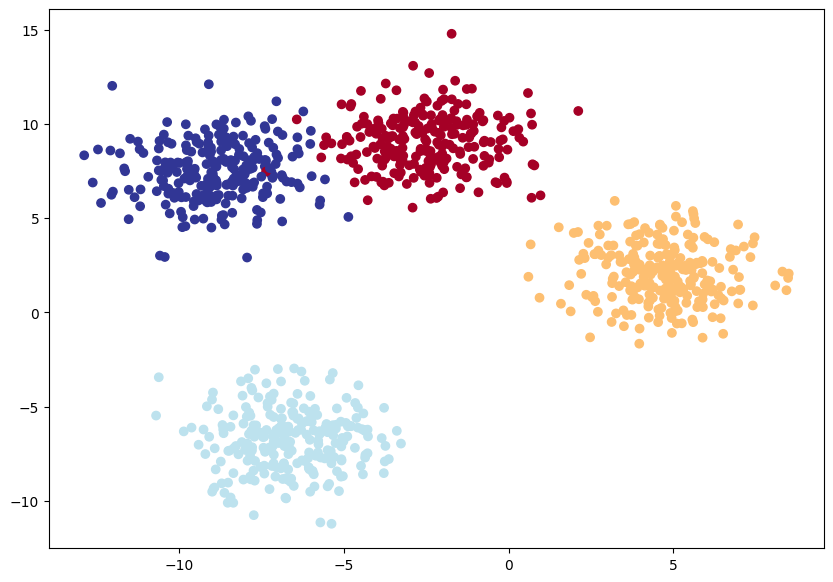

In [61]:
# Creating toy multi-class datasets

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # giving a bit of randomness
                            random_state=RANDOM_SEED)

# Turn data into tensors, sklearn uses numpy
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [62]:
# Device agnostic code

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

device

'cpu'

In [63]:
# Multiclass classification model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input_features to the model
      output_features (int): Number of outputs (no. of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance and send to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [64]:
X_blob_train.shape, torch.unique(y_blob_train)

(torch.Size([800, 2]), tensor([0, 1, 2, 3]))

In [65]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [66]:
# Get raw outputs (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

### Convert the logits to prediction probabilities (use torch.softmax) then prediction labels (use torch.argmax)



In [67]:
# Use an activation function to change the logits to prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [68]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [69]:
torch.argmax(y_pred_probs[0]) # Class index of highest probabilty

tensor(1)

In [70]:
# Convert prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [71]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

# Training and testing loop

In [72]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train) #loss fn takes in input logits
  acc = accuracy_fn(y_blob_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epochs: {epoch} | Training loss: {loss:.4f}, Training accuracy: {acc:.2f}% | Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")


Epochs: 0 | Training loss: 1.1588, Training accuracy: 40.38% | Test loss: 1.0755, Test accuracy: 48.00%
Epochs: 10 | Training loss: 0.6448, Training accuracy: 96.75% | Test loss: 0.6607, Test accuracy: 97.50%
Epochs: 20 | Training loss: 0.4254, Training accuracy: 98.50% | Test loss: 0.4307, Test accuracy: 100.00%
Epochs: 30 | Training loss: 0.2529, Training accuracy: 99.12% | Test loss: 0.2451, Test accuracy: 99.50%
Epochs: 40 | Training loss: 0.1123, Training accuracy: 99.25% | Test loss: 0.1023, Test accuracy: 99.50%
Epochs: 50 | Training loss: 0.0663, Training accuracy: 99.25% | Test loss: 0.0585, Test accuracy: 99.50%
Epochs: 60 | Training loss: 0.0507, Training accuracy: 99.25% | Test loss: 0.0429, Test accuracy: 99.50%
Epochs: 70 | Training loss: 0.0430, Training accuracy: 99.25% | Test loss: 0.0349, Test accuracy: 99.50%
Epochs: 80 | Training loss: 0.0384, Training accuracy: 99.25% | Test loss: 0.0299, Test accuracy: 99.50%
Epochs: 90 | Training loss: 0.0352, Training accuracy: 

In [73]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]])

In [74]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[    0.0013,     0.9987,     0.0000,     0.0000],
        [    0.0050,     0.0001,     0.0011,     0.9939],
        [    0.0014,     0.0009,     0.9946,     0.0031],
        [    0.0047,     0.9948,     0.0003,     0.0001],
        [    0.9939,     0.0061,     0.0000,     0.0000],
        [    0.0013,     0.0000,     0.0003,     0.9983],
        [    0.0029,     0.0022,     0.9878,     0.0071],
        [    0.9984,     0.0006,     0.0000,     0.0010],
        [    0.0003,     0.0002,     0.9988,     0.0008],
        [    0.9983,     0.0015,     0.0000,     0.0003]])

In [75]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [76]:
y_pred = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

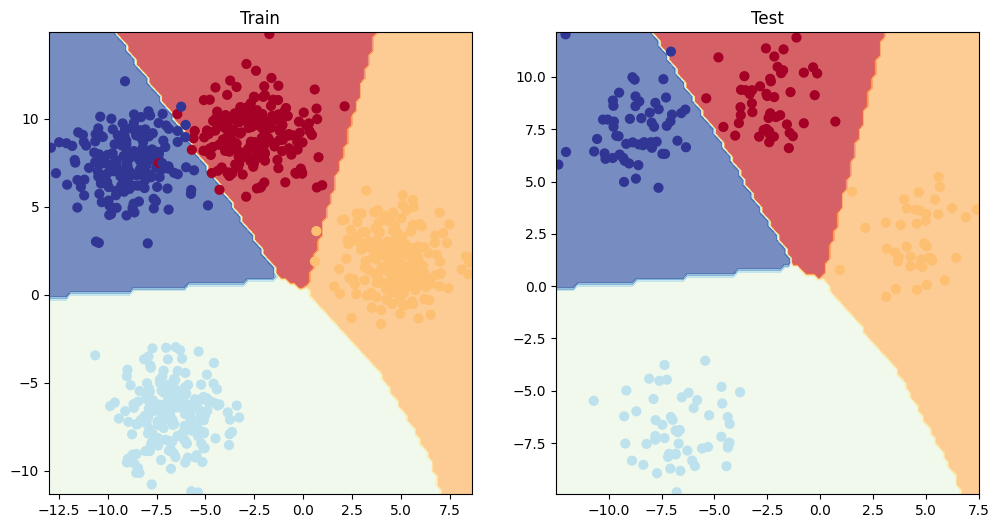

In [77]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### A few more classification metrics (evaluate our model)

* Accuracy (best for balanced classes)
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [31]:
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.1 MB/s eta 0:00:00


In [83]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_pred, y_blob_test)

tensor(0.9950)

## EXERCISES

In [2]:
# Q1
import torch
# Device
if torch.cuda.is_available():
  device="cuda"

else:
  device="cpu"
device

'cuda'

In [15]:
from sklearn.datasets import make_moons

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Hyperparameters
NUM_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=NUM_SAMPLES,
                  noise=0.03,
                  random_state=RANDOM_SEED)

In [8]:
X[:5]

array([[-0.00933187,  0.39098105],
       [ 0.95457387, -0.47375583],
       [ 0.9185256 , -0.42519648],
       [ 0.41276802, -0.37638459],
       [-0.84532016,  0.52879908]])

In [12]:
import pandas as pd

data_df = pd.DataFrame({"X0": X[:, 0],
                       "X1": X[:, 1],
                       "y": y})

data_df.head()

,X0,X1,y
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


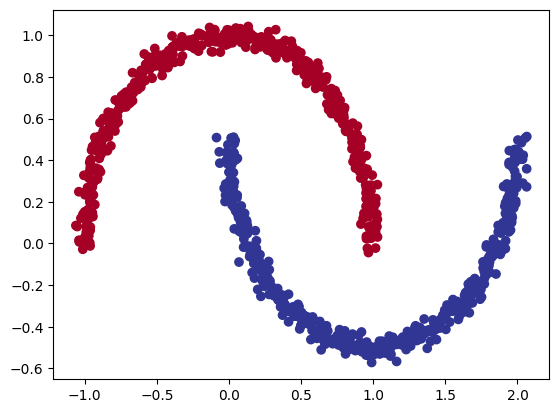

In [13]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [38]:
# Turn to tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

from sklearn.model_selection import train_test_split
# Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

<ipython-input-38-0448d842ab7e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float)
<ipython-input-38-0448d842ab7e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float)


In [68]:
from torch import nn

class ExerciseModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
      return self.layers(x)

exercise_model = ExerciseModel(2, 1, 10).to(device)

In [69]:
# Loss fn
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params=exercise_model.parameters(),
                            lr=0.1)

In [70]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)

In [71]:
# Training and testing loop

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  exercise_model.train()
  y_logits = exercise_model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  exercise_model.eval()
  with torch.inference_mode():
    test_logits = exercise_model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Training loss: {loss:.4f}, Training acc: {acc*100}% | Test loss: {test_loss:.4f}, Test acc: {test_acc*100}%")

Epoch: 0 | Training loss: 0.6809, Training acc: 79.875% | Test loss: 0.6808, Test acc: 76.0%
Epoch: 100 | Training loss: 0.4012, Training acc: 82.75% | Test loss: 0.4163, Test acc: 78.0%
Epoch: 200 | Training loss: 0.2598, Training acc: 87.125% | Test loss: 0.2610, Test acc: 87.0%
Epoch: 300 | Training loss: 0.2193, Training acc: 89.5% | Test loss: 0.2147, Test acc: 91.5%
Epoch: 400 | Training loss: 0.1907, Training acc: 90.75% | Test loss: 0.1847, Test acc: 92.5%
Epoch: 500 | Training loss: 0.1530, Training acc: 93.5% | Test loss: 0.1464, Test acc: 94.5%
Epoch: 600 | Training loss: 0.1088, Training acc: 95.5% | Test loss: 0.1014, Test acc: 97.0%
Epoch: 700 | Training loss: 0.0707, Training acc: 98.625% | Test loss: 0.0639, Test acc: 98.5%
Epoch: 800 | Training loss: 0.0460, Training acc: 99.375% | Test loss: 0.0403, Test acc: 99.5%
Epoch: 900 | Training loss: 0.0314, Training acc: 100.0% | Test loss: 0.0270, Test acc: 100.0%


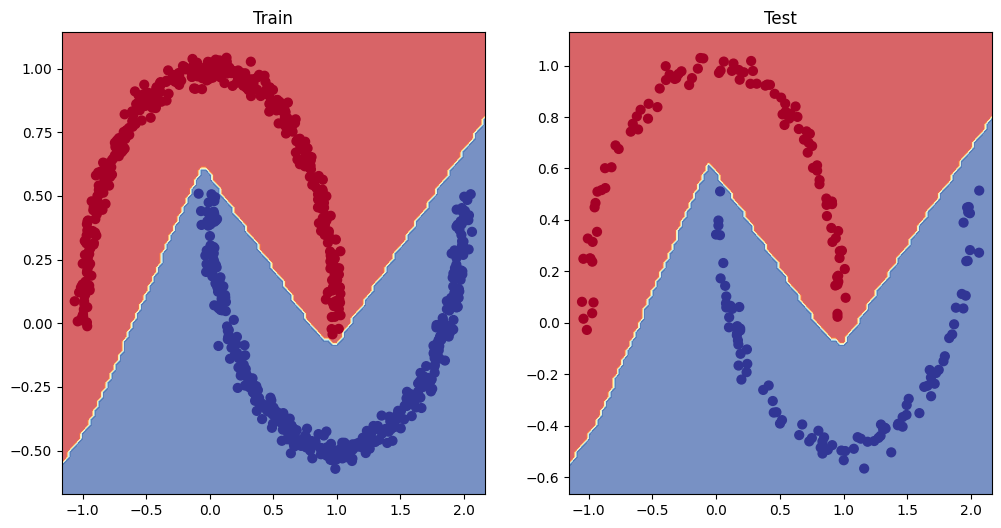

In [72]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(exercise_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(exercise_model, X_test, y_test)